# How is US hazelnut production affected by inter-annual weather variation in the Willamette Valley of Oregon?

[Readme](README.md) (Maybe move the original problem statment document to here)

# Notebook1
If you are viewing on Git, the links below may not work; for that or other issues try the [alternate render](https://nbviewer.jupyter.org/github/sbBEM/cap2/blob/master/cap2_NB01.ipynb).

Table of contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Datasources](#Datasources)
    - [Datasource exploration](#Datasourceexploration)
    - [Loading of stations data](#Loadingofstationsdata)
    - [Loading of weather data](#Loadingofweatherdata)
    - [Loading of crop data](#Loadingofcropdata)
    - [Exporting data](#Exportingdata)

[Next Notebook](cap2_NB02.ipynb)

- [Test of Github compatible link to Exporting data](cap2_NB01.ipynb#Exportingdata)

## Introduction <a name="Introduction"></a>
How has the weather changed in the Willamette Valley of Oregon over the past century and how might it change in the future? How does this affect the farming of hazelnuts? Can we predict future yeilds? Our problem [definition document](https://docs.google.com/document/d/e/2PACX-1vQUFz0qQxgQtwzNAYBzw6CHJeG7u9g2AET1GSUUud74tMy0n0sHF8wzw5AdeIljYDjmY6qghmqlJUu0/pub) contains the details, including the specifics of the crop, geographic region, weather properties, & time periods. 

## Imports <a name="Imports"></a>
Loading Python modules and Notebook extentions.

In [36]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import google.cloud.bigquery as bq
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from io import BytesIO
from zipfile import ZipFile
import requests
from IPython.core.display import display, HTML
import tabula

In [3]:
%load_ext google.cloud.bigquery
%load_ext autoreload
%autoreload 2

For the API, the enviroment variable has been set to read credentials from outside the repo. Details in [envs.sh](../envs.sh). 
Reference for generating a new key [here](https://cloud.google.com/docs/authentication/getting-started).

## Datasources <a name="Datasources"></a>
As a weather datasource, I’ve selected the [NOAA](www.noaa.gov) public dataset on [Google Bigquery](https://console.cloud.google.com/marketplace/details/noaa-public/gsod).
This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center. This dataset covers GSOD data between 1929 and present, collected from over 9000 stations. 
The dataset ID is: 'bigquery-public-data:noaa_gsod'

To query, we will use Python API and move the data we need into Panda dataframes. 

We will also be using the reference points along our river of interest which we listed earlier, including their [geodata](https://geohack.toolforge.org/geohack.php?pagename=Cottage_Grove,_Oregon&params=43_47_41_N_123_3_9_W_type:city_region:US-OR): 


In [4]:
region_points = {
'Eugene': [44.051, -123.086], 
'Corvallis': [44.566, -123.283],
'Salem': [44.939, -123.039],
'Portland': [45.520, -122.681]
}

###  Datasource exploration <a name="Datasourceexploration"></a>
We will do some initial exploration of the data structure and contents. We need to determine if we have what we need for our study. 

In [5]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`

,table_catalog,table_schema,table_name,column_name,field_path,data_type,description
0,bigquery-public-data,noaa_gsod,gsod2020,date,date,DATE,Date of the weather observations
1,bigquery-public-data,noaa_gsod,gsod2021,date,date,DATE,Date of the weather observations
2,bigquery-public-data,noaa_gsod,stations,usaf,usaf,STRING,
3,bigquery-public-data,noaa_gsod,stations,name,name,STRING,
4,bigquery-public-data,noaa_gsod,stations,country,country,STRING,
...,...,...,...,...,...,...,...
2984,bigquery-public-data,noaa_gsod,gsod1966,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2985,bigquery-public-data,noaa_gsod,gsod1932,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2986,bigquery-public-data,noaa_gsod,gsod2019,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."
2987,bigquery-public-data,noaa_gsod,gsod2014,tornado_funnel_cloud,tornado_funnel_cloud,STRING,"Indicators (1 = yes, 0 = no/not reported) for ..."


In [6]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMNS`

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,bigquery-public-data,noaa_gsod,gsod2000,stn,1,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
1,bigquery-public-data,noaa_gsod,gsod2000,wban,2,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2,bigquery-public-data,noaa_gsod,gsod2000,year,3,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
3,bigquery-public-data,noaa_gsod,gsod2000,mo,4,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
4,bigquery-public-data,noaa_gsod,gsod2000,da,5,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,bigquery-public-data,noaa_gsod,gsod2003,rain_drizzle,28,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2985,bigquery-public-data,noaa_gsod,gsod2003,snow_ice_pellets,29,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2986,bigquery-public-data,noaa_gsod,gsod2003,hail,30,YES,STRING,NEVER,None,None,NO,None,NO,NO,None
2987,bigquery-public-data,noaa_gsod,gsod2003,thunder,31,YES,STRING,NEVER,None,None,NO,None,NO,NO,None


We are seeing thousands of columns because the data is broken up into a separate table for every year. 

In [7]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.TABLES`

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time
0,bigquery-public-data,noaa_gsod,gsod2000,BASE TABLE,YES,NO,2016-03-14 02:55:34.341000+00:00
1,bigquery-public-data,noaa_gsod,gsod2001,BASE TABLE,YES,NO,2016-03-14 02:55:31.232000+00:00
2,bigquery-public-data,noaa_gsod,gsod1933,BASE TABLE,YES,NO,2016-03-14 02:55:02.293000+00:00
3,bigquery-public-data,noaa_gsod,gsod1942,BASE TABLE,YES,NO,2016-03-14 02:55:06.381000+00:00
4,bigquery-public-data,noaa_gsod,gsod1963,BASE TABLE,YES,NO,2016-03-14 02:55:17.608000+00:00
...,...,...,...,...,...,...,...
89,bigquery-public-data,noaa_gsod,gsod1966,BASE TABLE,YES,NO,2016-03-14 02:55:15.947000+00:00
90,bigquery-public-data,noaa_gsod,gsod1932,BASE TABLE,YES,NO,2016-03-14 02:55:01.279000+00:00
91,bigquery-public-data,noaa_gsod,gsod2019,BASE TABLE,YES,NO,2019-01-11 17:03:04.031000+00:00
92,bigquery-public-data,noaa_gsod,gsod2014,BASE TABLE,YES,NO,2016-03-14 02:55:37.586000+00:00


To aggregate the tables for every year, we will use table queries with a wildcard ‘gsod*’.

In [8]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.gsod*`
Limit 10

,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,060300,99999,None,1942,12,30,28.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
1,061600,99999,None,1942,02,06,18.5,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
2,061600,99999,None,1942,02,14,23.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
3,061600,99999,None,1942,02,22,21.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
4,061600,99999,None,1942,02,27,13.0,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
5,061600,99999,None,1942,03,09,31.2,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
6,071950,99999,None,1942,02,05,28.0,4,25.0,4,...,None,99.99,None,999.9,0,0,1,0,0,0
7,101620,99999,None,1942,01,20,11.3,4,9999.9,0,...,None,99.99,None,999.9,0,0,1,0,0,0
8,101730,99999,None,1942,01,09,23.5,4,20.3,4,...,None,99.99,None,999.9,0,0,1,0,0,0
9,101800,99999,None,1942,01,31,17.7,4,14.8,4,...,None,99.99,None,999.9,0,0,1,0,0,0


Many fields have place-holder values of 99.99 or similar so we will have to do cleaning but for now we continue exploring. 

In [9]:
%%bigquery
SELECT count(*)
FROM `bigquery-public-data.noaa_gsod.gsod*`

,f0_
0,159958432


So there are 159+ million of these daily records available. Each record is for readings of all of the weather properties by that station on that day. 

The only other table we see is for info about the weather stations. We will need it to narrow down our weather data to only our region of interest. 

In [10]:
%%bigquery
SELECT column_name, data_type, description
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'stations'

,column_name,data_type,description
0,usaf,STRING,
1,wban,STRING,
2,name,STRING,
3,country,STRING,
4,state,STRING,
5,call,STRING,
6,lat,FLOAT64,
7,lon,FLOAT64,
8,elev,STRING,
9,begin,STRING,


In [11]:
%%bigquery
SELECT column_name, data_type, description
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'gsod1963'

,column_name,data_type,description
0,stn,STRING,Station number (WMO/DATSAV3 number) for the lo...
1,wban,STRING,WBAN number where applicable--this is the hist...
2,year,STRING,The year
3,mo,STRING,The month
4,da,STRING,The day
5,temp,FLOAT64,Mean temperature for the day in degrees Fahren...
6,count_temp,INT64,Number of observations used in calculating mea...
7,dewp,FLOAT64,Mean dew point for the day in degreesm Fahrenh...
8,count_dewp,INT64,Number of observations used in calculating mea...
9,slp,FLOAT64,Mean sea level pressure for the day in milliba...


The NOAA collects hourly data so trends can be seen over different times of day. 
Here, there is no field for hour or time so this dataset must be of daily summaries of the hourly data. 
For our purposes, that will be sufficient. 
It looks like 'usaf' is sometimes the common index between stations and weather but for other records 'wban' is the common index. We should be able to do the table join on both indexes. 

#### Loading of stations data <a name="Loadingofstationsdata"></a>
We will not be loading our actual weather data until we have narrowed down our stations to table join with. 

In [12]:
%%bigquery stationsdf
SELECT
usaf as station_id1,
wban as station_id2, 
name, state, lat, lon, elev
FROM `bigquery-public-data.noaa_gsod.stations`

In [13]:
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev
0,007018,99999,WXPOD 7018,None,0.00,0.000,+7018.0
1,007026,99999,WXPOD 7026,None,0.00,0.000,+7026.0
2,007070,99999,WXPOD 7070,None,0.00,0.000,+7070.0
3,008268,99999,WXPOD8278,None,32.95,65.567,+1156.7
4,008307,99999,WXPOD 8318,None,0.00,0.000,+8318.0


Some stations have lat/lon set to 0.00. 

In [14]:
%%bigquery
SELECT count(*) 
FROM `bigquery-public-data.noaa_gsod.stations`
WHERE lat = 0

,f0_
0,385


So we have 385 stations with no location data. 

In [15]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.stations`
WHERE usaf = '007018'

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.0,0.0,+7018.0,20110309,20130730


In [16]:
%%bigquery
SELECT *
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE stn = '007018'
Limit 100

,stn,wban,date,year,mo,da,temp,count_temp,dewp,count_dewp,...,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,007018,99999,None,2013,07,12,74.4,24,74.2,24,...,*,0.0,I,999.9,0,0,0,0,0,0
1,007018,99999,None,2013,07,13,76.9,24,76.1,24,...,*,0.0,I,999.9,0,0,0,0,0,0
2,007018,99999,None,2013,07,19,81.6,15,75.7,15,...,*,0.0,I,999.9,0,0,0,0,0,0
3,007018,99999,None,2013,07,29,81.0,9,71.8,9,...,*,0.0,I,999.9,0,0,0,0,0,0
4,007018,99999,None,2013,07,14,79.6,24,77.3,24,...,*,0.0,I,999.9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,007018,99999,None,2011,03,23,75.1,24,50.7,24,...,*,0.0,I,999.9,0,0,0,0,0,0
96,007018,99999,None,2011,04,18,69.7,24,44.2,24,...,*,0.0,I,999.9,0,0,0,0,0,0
97,007018,99999,None,2011,04,27,77.0,24,70.6,24,...,*,0.0,I,999.9,0,0,0,0,0,0
98,007018,99999,None,2011,05,14,76.9,24,66.7,24,...,*,0.0,I,999.9,0,0,0,0,0,0


The locations do have weather data but we won't be able to use them unless there's a way to get their location information. 

In [17]:
# Check our imported data types
stationsdf.dtypes

station_id1     object
station_id2     object
name            object
state           object
lat            float64
lon            float64
elev            object
dtype: object

In [18]:
# Fix elevation to be numeric
stationsdf.elev = pd.to_numeric(stationsdf.elev)

In [19]:
stationsdf.dtypes

station_id1     object
station_id2     object
name            object
state           object
lat            float64
lon            float64
elev           float64
dtype: object

In [20]:
stationsdf.describe()

,lat,lon,elev
count,28376.000000,28375.000000,28277.000000
mean,30.601721,-2.973474,346.074294
std,28.902741,87.264746,591.771837
min,-90.000000,-179.983000,-999.900000
25%,20.716500,-82.566500,22.000000
50%,39.000000,6.110000,138.000000
75%,49.783000,60.175000,433.000000
max,83.650000,179.750000,8318.000000


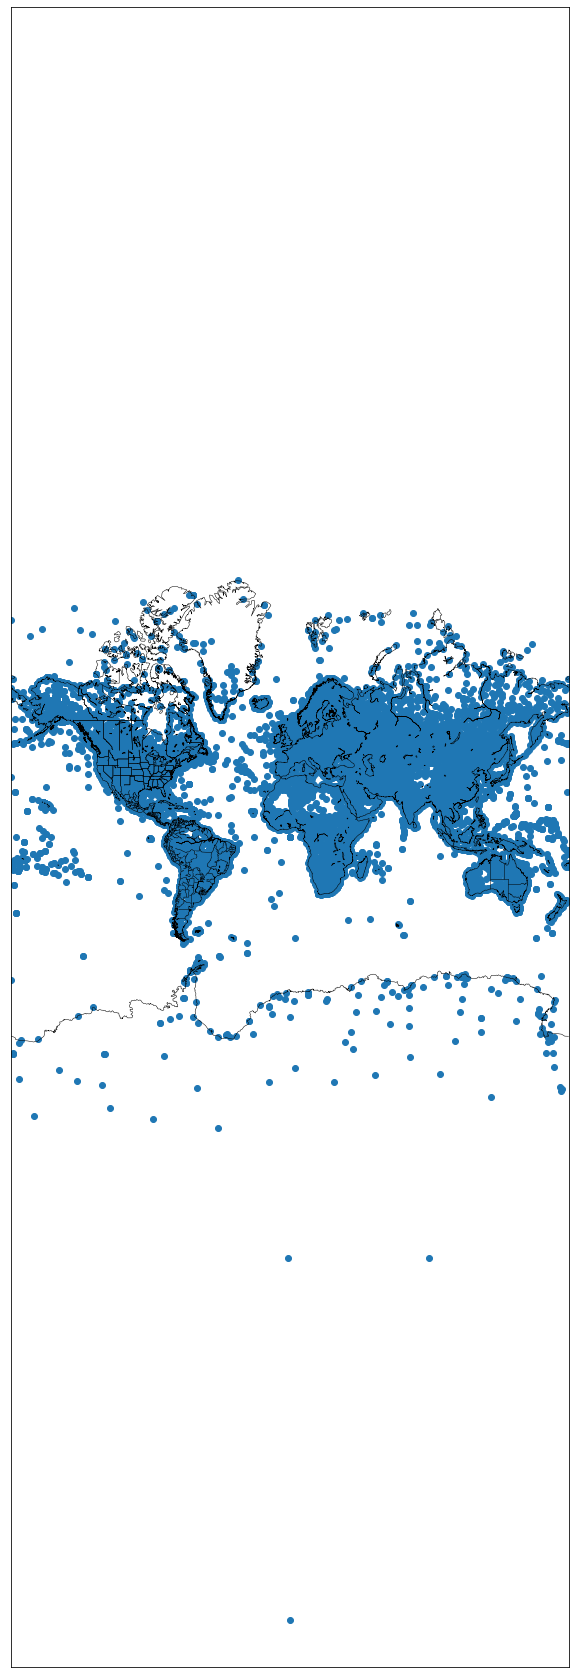

In [21]:
# Plot the station locations for us to see
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,50)
m = Basemap(resolution='l',projection='merc')
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y)

Hundreds of stations have only 0,0 coordinates but enough others appear to have valid location data that we are reading correctly. 

We will calculate the distances between the stations and each of our region points. To do so, we apply the archaversine after computing the haversine of the central angle as described [here](https://en.wikipedia.org/wiki/Haversine_formula#Formulation) and shown below: 

In [22]:
%%latex
\begin{align}
  d &= 2r \arcsin\left(\sqrt{\operatorname{hav}(\varphi_2 - \varphi_1) + \cos(\varphi_1) \cos(\varphi_2)\operatorname{hav}(\lambda_2 - \lambda_1)}\right) \\
    &= 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)
\end{align}

<IPython.core.display.Latex object>

Using the produced distances will allow us to drop all stations outside our region from our selection before we join it with the weather data table. 

In [23]:
# Put the equation in a fuction
def rarchavh(point1lat, point1lon, point2lat, point2lon):
    """
    return the distance between two points
    https://en.wikipedia.org/wiki/Haversine_formula#Formulation
    """
    r = 6378 # radius of Earth in km
    phi1, lam1, phi2, lam2 = [np.radians(p) for p in [point1lat, point1lon, point2lat, point2lon]] # radians
    h = np.sin((phi2-phi1)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lam2-lam1)/2)**2 # haversine
    d = 2 * r * np.arcsin(h**.5) # spherical distance = r archav(root of h)
    return d

In [24]:
#Get distances from each of our reference points in the region
for k, v in region_points.items():
    stationsdf['dist'+k] = rarchavh(
        v[0], v[1], stationsdf.lat, stationsdf.lon)

In [25]:
# Observe we have distance columns now
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev,distEugene,distCorvallis,distSalem,distPortland
0,007018,99999,WXPOD 7018,None,0.00,0.000,7018.0,12590.038891,12580.491203,12545.614905,12493.144656
1,007026,99999,WXPOD 7026,None,0.00,0.000,7026.0,12590.038891,12580.491203,12545.614905,12493.144656
2,007070,99999,WXPOD 7070,None,0.00,0.000,7070.0,12590.038891,12580.491203,12545.614905,12493.144656
3,008268,99999,WXPOD8278,None,32.95,65.567,1156.7,11420.650612,11361.763195,11323.105059,11262.462705
4,008307,99999,WXPOD 8318,None,0.00,0.000,8318.0,12590.038891,12580.491203,12545.614905,12493.144656


In [26]:
# We are interested in the shortest of the distances for each station. 
stationsdf['distMin'] = stationsdf.iloc[:, -1:-len(region_points)-1:-1].min(axis=1)

In [27]:
# Observe our new column
stationsdf.head()

,station_id1,station_id2,name,state,lat,lon,elev,distEugene,distCorvallis,distSalem,distPortland,distMin
0,007018,99999,WXPOD 7018,None,0.00,0.000,7018.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
1,007026,99999,WXPOD 7026,None,0.00,0.000,7026.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
2,007070,99999,WXPOD 7070,None,0.00,0.000,7070.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656
3,008268,99999,WXPOD8278,None,32.95,65.567,1156.7,11420.650612,11361.763195,11323.105059,11262.462705,11262.462705
4,008307,99999,WXPOD 8318,None,0.00,0.000,8318.0,12590.038891,12580.491203,12545.614905,12493.144656,12493.144656


Let's see what these look like, as a sanity check

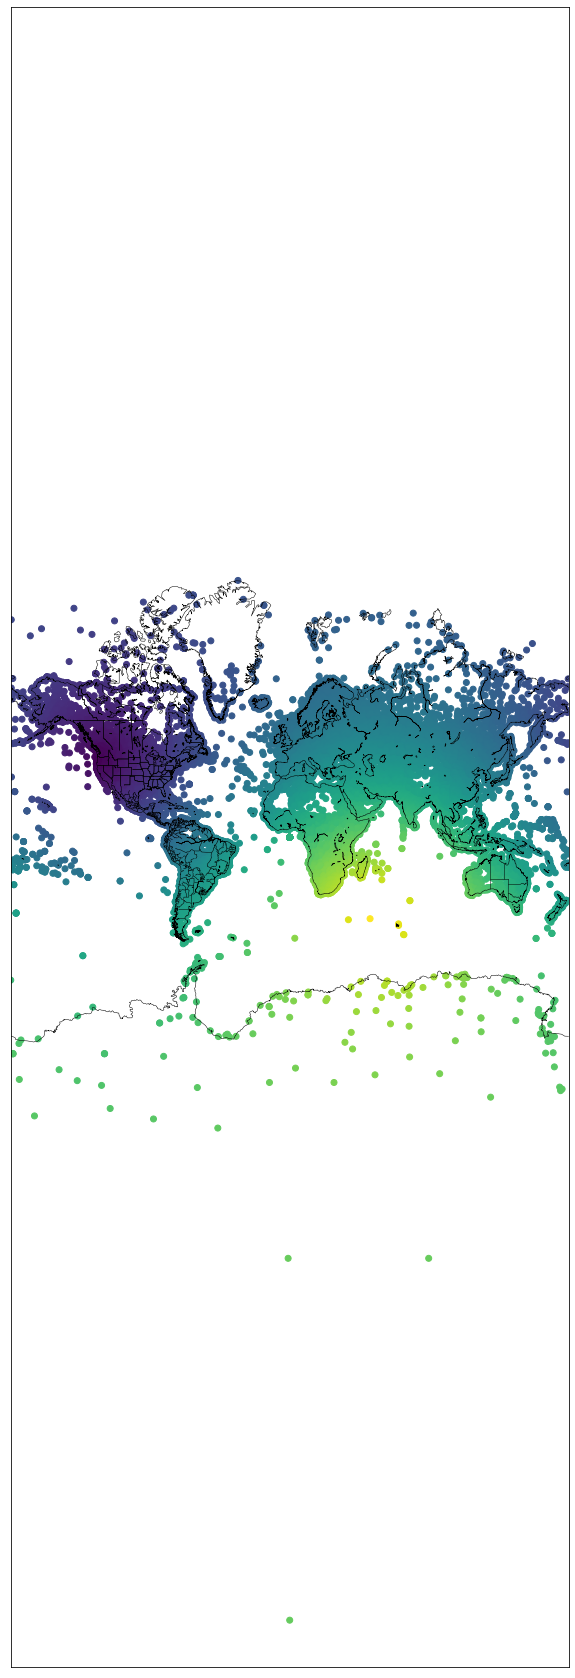

In [28]:
# Color stations by distance from Willamette: 
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,50)
m = Basemap(resolution='l',projection='merc')
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y, c=stationsdf['distMin'].values)

In [29]:
#We'll use this for a map centering point from now on
clat = region_points['Eugene'][0]
clon = region_points['Eugene'][1]

We'll zoom in a little and highlight our nearest stations

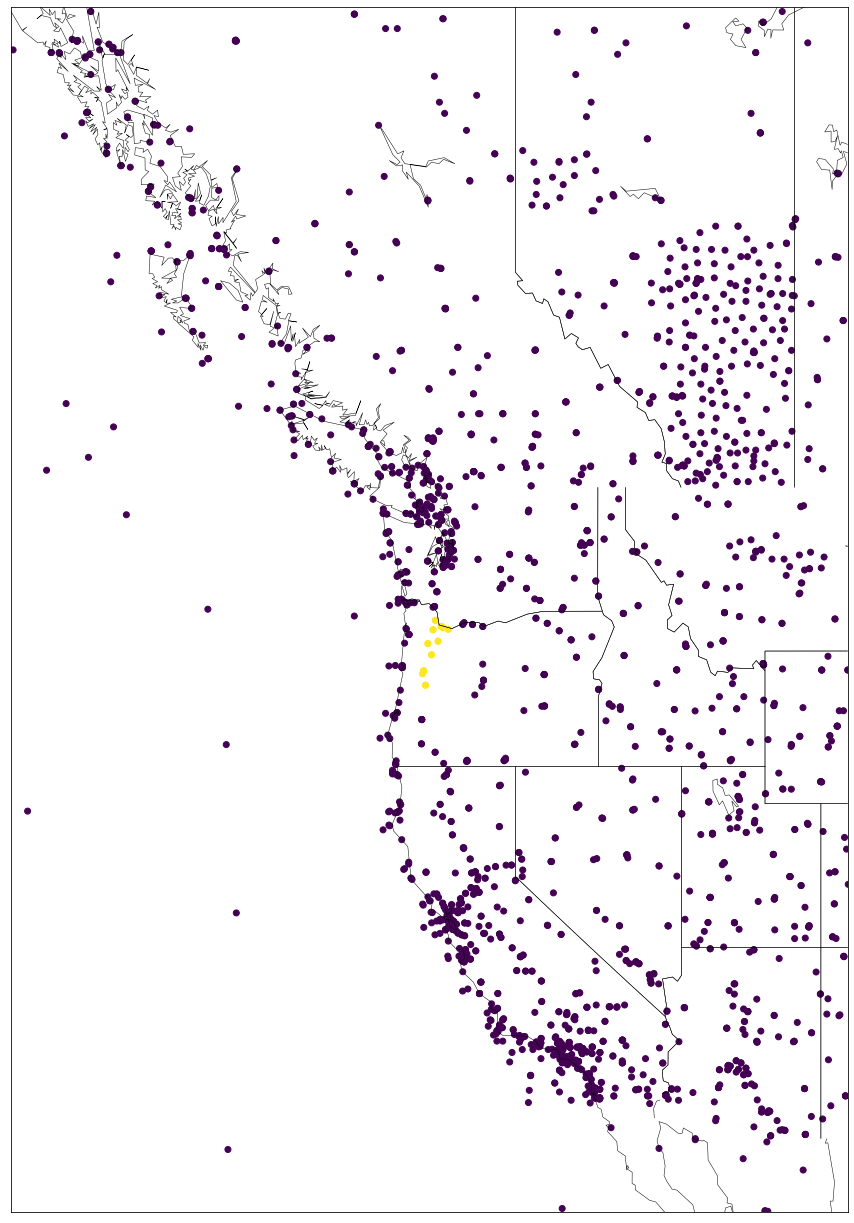

In [30]:
# Color code the nearby stations: 
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,50)
m = Basemap(resolution='l',projection='merc',  
           llcrnrlat=clat-15,urcrnrlat=clat+15,llcrnrlon=clon-15,urcrnrlon=clon+15,lat_ts=15.0)
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(stationsdf['lon'].values,stationsdf['lat'].values)
m.scatter(x,y, c=stationsdf['distMin'].values < 60)

Looks good so we'll put our stations of interest into a seperate dataframe. 

In [31]:
our_stations = stationsdf[
    (stationsdf.state == 'OR') & (stationsdf.elev < 500) & (stationsdf.distMin < 60)][
    ['station_id1', 'station_id2', 'name', 'lat', 'lon', 'elev', 'distMin']]

In [32]:
our_stations[:]

,station_id1,station_id2,name,lat,lon,elev,distMin
10257,999999,24248,CORVALLIS NAAS,44.500,-123.283,75.0,7.346929
14701,999999,24221,EUGENE MAHLON SWEET ARPT,44.128,-123.221,113.7,13.783134
14704,999999,24229,PORTLAND,45.596,-122.609,32.6,10.152165
14706,999999,24232,SALEM MCNARY FIELD,44.905,-123.001,61.3,4.826550
16431,726836,99999,SCAPPOOSE INDUSTRIAL,45.773,-122.867,18.0,31.665077
16433,726881,99999,MC MINNVILLE MUNI,45.183,-123.133,50.0,28.149047
16435,726945,99999,CORVALLIS MUNI,44.483,-123.283,75.0,9.239319
16436,726959,99999,AURORA STATE,45.250,-122.767,61.0,30.798502
16437,726986,99999,PORTLAND/HILLSBORO,45.533,-122.950,62.0,21.028200
16649,726985,99999,PORTLAND TROUTDALE,45.550,-122.400,12.0,22.163903


After applying our other restrictions, finally zoom all the way in showing state boundary and our selected stations

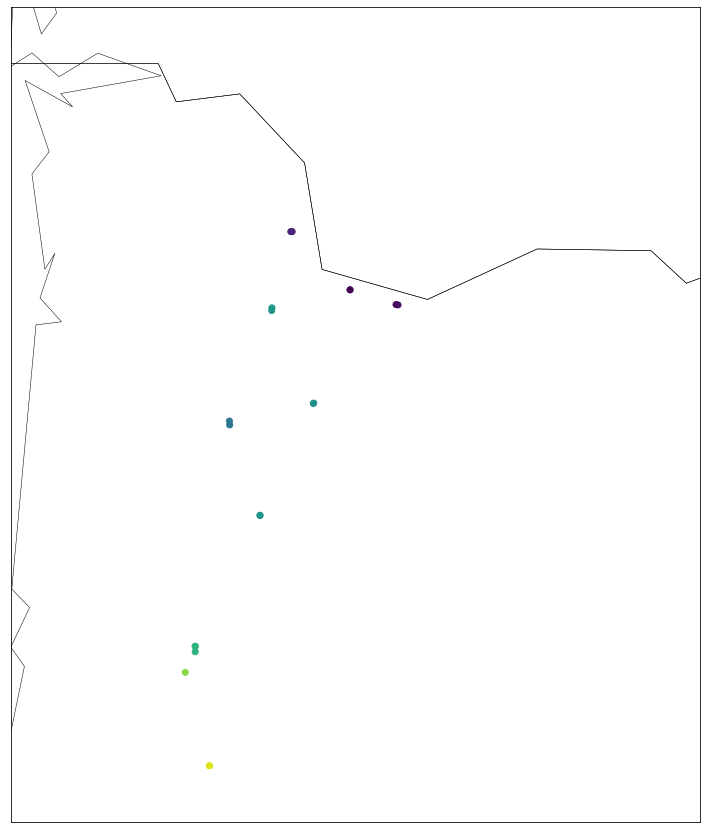

In [33]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,15)
m = Basemap(resolution='l',projection='merc',  
           llcrnrlat=clat-0.1,urcrnrlat=clat+2.4,llcrnrlon=clon-1,urcrnrlon=clon+2,lat_ts=0)
m.drawstates(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
x,y = m(our_stations['lon'].values,our_stations['lat'].values)
m.scatter(x,y, c=our_stations['elev'].values)

Colored for elevation, we see the lowest stations are closest to the river's confluence in the North, while the highest stations are nearest its headwaters.
We ended up with only 20 valid stations but they have a pretty good spread over our region of interest so we are going to proceed with this data. 

#### Loading of weather data <a name="Loadingofweatherdata"></a>
Now that we have selected our stations, we next want to query for our weather data. We will select only records for our stations of interest, using a table join.

#### Loading of crop data <a name="Loadingofcropdata"></a>
We will load the annual hazelut yields as well as the farming land area used. 
- The csv formatted data for 1927 to 1976 and another for 1977 to 2008 are online in [this USDA zip file](https://www.nass.usda.gov/Statistics_by_State/Oregon/Publications/Historical_Data/nuts/hazelnuthist_csv.zip)
- Years 2009 to 2010 appear to be unavailable. 
- Years 2011 to 2020 are on page 52 of [this USDA PDF file](https://www.nass.usda.gov/Statistics_by_State/Oregon/Publications/Annual_Statistical_Bulletin/2020/ODA%20ag%20stat_directory%202021.pdf). We may have to import that table from the PDF if no csv is available. 

In [214]:
crop_zipurl = "https://www.nass.usda.gov/Statistics_by_State/Oregon/Publications/Historical_Data/nuts/hazelnuthist_csv.zip"
crop_zipname = requests.get(crop_zipurl).content
archive = ZipFile( BytesIO(crop_zipname) , 'r')
archive.printdir()

File Name                                             Modified             Size
help.htm                                       2009-12-10 13:59:04         2377
indx.htm                                       2009-12-10 13:59:04         1199
_049.csv                                       2009-12-10 13:59:04         3617
_050.csv                                       2009-12-10 13:59:04         2870
_051.csv                                       2009-12-10 13:59:04         2752
_all.csv                                       2009-12-10 13:59:04         9239


In [37]:
help_HTML = HTML( archive.open('help.htm').read().decode('utf-8') )
index_HTML = HTML( archive.open('indx.htm').read().decode('utf-8') )

In [38]:
#let's see the index: 
index_HTML

For some reason, two of the files have overlapping dates. 
We will ignore "051.csv" and "all.csv". 
Reading the remaining files, "049.csv" & "050.csv", into a dataframe should give everything we need from this zip.

In [39]:
nonoverlapping_names = ['_049.csv', '_050.csv']

In [40]:
#let's read the help: 
help_HTML

The above help document shows each csv has: 
- two title rows, then 
- four header rows, then our column name row, then another header row, then
- a units row, then 
- data rows, then 
- a closing row, then
- three footer rows, then
- a blank line

In [41]:
cropdf = pd.concat(
    [pd.read_csv(archive.open(f), # open each csv in our list
                 header=0, # header is 0 if we skip the rows around it
                 skipfooter=4, # the trailing 5 lines of each file are unwanted
                 skiprows=list(range(0,6)) + [7, 8], # unwanted rows before and after header
                 encoding='utf-8', # 
                 engine='python' # because "c" engine not feature complete
                ) for f in nonoverlapping_names], ignore_index = True)
cropdf

,49,h,Year,acreage,per acre,Utilized,Production 3/,Shell,Shelled,per ton,Production,50
0,49.0,d,1927,-,-,60,-,-,-,320.0,19,NaN
1,49.0,d,1928,-,-,200,-,-,-,380.0,76,NaN
2,49.0,d,1929,2000,0.10,200,-,-,-,300.0,60,NaN
3,49.0,d,1930,2500,0.12,300,-,-,-,340.0,102,NaN
4,49.0,d,1931,3100,0.12,380,-,-,-,250.0,95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
77,NaN,d,2004,28400,1.32,37500,5900,22000,15500,1440.0,54000,50.0
78,NaN,d,2005,28300,0.98,27600,4900,14600,13000,2240.0,61824,50.0
79,NaN,d,2006,28200,1.52,43000,8200,24000,19000,1080.0,46440,50.0
80,NaN,d,2007,28600,1.29,37000,4800,24900,12100,2040.0,75480,50.0


In [42]:
crop_PDFURL = "https://www.nass.usda.gov/Statistics_by_State/Oregon/Publications/Annual_Statistical_Bulletin/2020/ODA%20ag%20stat_directory%202021.pdf"

To get the remaining crop data, we will extract our table of interest from this PDF. 

In [96]:
page52 = tabula.read_pdf(crop_PDFURL, multiple_tables = True, pages=52)

In [97]:
len(page52)

3

In [146]:
#We are only interested in the last table on the page
rawdf = page52[-1]
rawdf

,0,1,2,3
0,Bearing\racreage,Yield per acre 1,Utilized\rproduction,Price
1,"(acres)\r28,500\r29,000\r30,000\r30,000\r34,00...",(tons)\r1.35\r1.22\r1.50\r1.20\r0.91\r1.19\r0....,"(tons)\r38,500\r35,500\r45,000\r36,000\r31,000...","(dollars per ton)\r2,330\r1,830\r2,680\r3,600\..."


It appears there's only a single row because our import failed to consider carriage returns as new lines. 
We will need to delimit them. Each string in the data row is actually an entire column. Also, the last column didn't import or is mixed up with another column. It would have been "Value of utilized production" but we won't need that column. Also, the year column is missing; we will have to fill it in. 

In [235]:
# extract our data as list of lists
cropcols = [x[1].split('\r') for x in rawdf.T[1].iteritems()]
# let's look at the first element to make sure it looks like a column of crop data: 
cropcols[0]

['(acres)',
 '28,500',
 '29,000',
 '30,000',
 '30,000',
 '34,000',
 '37,000',
 '40,000',
 '44,000',
 '50,000',
 '(NA)']

In [230]:
# Generate the missing first column (including the units-row we'll later drop)
yearscol = ['(years)'] + list(range(2011,2021))
yearscol

['(years)', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [242]:
# our other datasource is in cropdf but we aren't ready to combine them so use df2
cropdf2 = pd.DataFrame()
cropdf2['year'] = yearscol

In [240]:
cropheaders = [
    'Area', # Only the "Bearing" land area, in acres, or total area if unavailable
    'Yield', # This is untilized produce per unit of land (tons/acre)
    'Utilized', # Total production, in tons, minus discarded low quality or damaged tons
    'Price' # $/ton average market price
]

In [241]:
for h, c in zip(cropheaders, cropcols): 
    cropdf2[h] = c
cropdf2

,year,Area,Yield,UtilizedPrice,Utilized,Price
0,(years),(acres),(tons),(tons),(tons),(dollars per ton)
1,2011,"28,500",1.35,"38,500","38,500","2,330"
2,2012,"29,000",1.22,"35,500","35,500","1,830"
3,2013,"30,000",1.50,"45,000","45,000","2,680"
4,2014,"30,000",1.20,"36,000","36,000","3,600"
5,2015,"34,000",0.91,"31,000","31,000","2,800"
6,2016,"37,000",1.19,"44,000","44,000","2,700"
7,2017,"40,000",0.80,"32,000","32,000","2,300"
8,2018,"44,000",1.16,"51,000","51,000","1,800"
9,2019,"50,000",0.88,"44,000","44,000","1,920"


#### Exporting data <a name="Exportingdata"></a>

Here we'll save the data to files for loading by later notebooks

In [244]:
#weatherdf.to_pickle("../data/weather.pkl")
our_stations.to_pickle("../data/station.pkl")
cropdf.to_pickle("../data/crop.pkl")
cropdf2.to_pickle("../data/crop2.pkl")
#region_points.to_pickle("../data/region.pkl")

Work will continue in [Notebook2](cap2_NB02.ipynb).